# Model selection

author: steeve.laquitaine@epfl.ch

**purpose**:   
* Model and quantify the relationship between ground truth detection accuracy and unit biological features
* Use a fractional logistic regression to predict whether a ground truth unit's sorting accuracy will be the threshold for a high-quality unit 80% accuracy 

**TODO**:
* fix the full model fitting 

### Setup

activate spikeinterf

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import warnings
import copy

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.models.Fr import dataloader as fr_dataloader
from src.nodes.models.Fr.models import FrModel

# SETUP PATHS
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
KS4 = data_conf["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
GT = data_conf["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
WIRED = data_conf["probe_wiring"]["full"]["output"]
BLUECFG = data_conf["dataeng"]["blueconfig"]
STUDY_FULL = data_conf["postprocessing"]["waveform"]["ground_truth"]["study"]
STUDY = data_conf["postprocessing"]["waveform"]["ground_truth"]["10m"]["study"]
PREP = data_conf["preprocessing"]["full"]["output"]["trace_file_path"]

# parameters
MS_BEFORE = 3
MS_AFTER = 3
DURATION_SEC = 600
DT = 1.3
N_MIN_SPIKES = 10

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

2024-09-26 11:21:38,176 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-26 11:21:38,267 - root - utils.py - get_config - INFO - Reading experiment config. - done


## (6m)Fr model

**method**:

* fractional regression model (GLM for binomial family with logit link).
* features are z-scored, which speed up training convergence by a factor of 2.
* main effect (features weights alone) and pairwise interaction weights are trained
* regularized with elasticnet (lasso L1 norm can be set with alpha = 0 else L2 with alpha=1)
    * the function minimized is -loglike/n + alpha*((1-L1\_wt)*|params|_2^2/2 + L1\_wt*|params|_1)
    * we set alpha to 0 and L1\wt to 1 (default) for Lasso, setting small weights to zero (feature selection)
* drop "model_template": values do not have sufficient repeats for cross-validation. The model crashes.
* training convergence:
    * statsmodel does not output the loss function at each iteration, so assessed r-squared convergence for increasing number of iterations [50, 100], and decreasing tolerance[1e-10, 1e-11]. R-squared converged at unit precision with 100 iterations and at a convergence tolerance of 1e-10 .

* best r-squared: 0.42
* the calculation of the r-squared with the pairwise interaction terms is not yet implemented.
    

In [10]:
# parameters
DATASET = True
EVAL = True

# create dataset
if DATASET:

    # create dataset
    dataset = fr_dataloader.load_dataset(
        KS4,
        GT,
        PREP,
        STUDY,
        duration_sec=DURATION_SEC,
        n_min_spikes=N_MIN_SPIKES,
    )

    # drop poor feature
    dataset = dataset.drop(columns=["model_template"])

    # set predictors
    predictors = dataset.columns.drop(
        [
            "sorting_accuracy",
        ]
    )

# evaluate the model
if EVAL:

    # instantiate the model
    frmodel = FrModel(predictors, "sorting_accuracy", order=1)

    # train and evaluate the model
    flc_results = frmodel.evaluate(
        dataset=dataset,
        seeds=np.arange(0, 100, 1),
        scale_data=True,
        regularization="elastic_net",
        maxiter=100,
        cnvrg_tol=1e-10,
        verbose=False,
    )
    print("model: ", frmodel.formula)
    display(flc_results["metric_stats"])

2024-09-26 11:40:19,899 - root - dataloader.py - load_dataset - INFO - CURATION ----------------------------
2024-09-26 11:40:19,902 - root - dataloader.py - load_dataset - INFO - nb of units before filtering by nb of spike: 1836
2024-09-26 11:40:19,906 - root - dataloader.py - load_dataset - INFO - nb after: 1836
2024-09-26 11:40:19,926 - root - dataloader.py - load_dataset - INFO - nb of units before filtering units with inf feature: 1836
2024-09-26 11:40:19,928 - root - dataloader.py - load_dataset - INFO - nb of units after: 1835
model:  sorting_accuracy ~ 1  + firing_rate + synapse_class + bAC + bIR + bNAC + bSTUT + cACint + cADpyr + cIR + cNAC + cSTUT + dNAC + dSTUT + layer_1 + layer_23 + layer_4 + layer_5 + layer_6 + distance + snr + spatial_extent + exc_mini_frequency + dynamics_holding_current


{'r2_median': 0.33928837780144666,
 'r2_std': 0.029867406599504466,
 'r2_ci95': 0.005854011693502875}

In [3]:
# display dataset
dataset.head()

,firing_rate,synapse_class,bAC,bIR,bNAC,bSTUT,cACint,cADpyr,cIR,cNAC,...,layer_23,layer_4,layer_5,layer_6,distance,snr,spatial_extent,exc_mini_frequency,dynamics_holding_current,sorting_accuracy
12165,0.025000,1,0,0,0,0,0,1,0,0,...,1,0,0,0,35.880408,4.923775,131.413913,0.013875,-0.015435,0.011364
15894,0.001667,1,0,0,0,0,0,1,0,0,...,1,0,0,0,37.130547,10.454591,657.307385,0.013875,-0.008798,0.007246
16652,0.016667,1,0,0,0,0,0,1,0,0,...,1,0,0,0,48.102859,10.589489,128.090230,0.013875,-0.012208,0.014925
17923,0.000000,1,0,0,0,0,0,1,0,0,...,1,0,0,0,40.293894,NaN,NaN,0.013875,-0.016666,0.000000
18371,0.361667,1,0,0,0,0,0,1,0,0,...,1,0,0,0,35.766017,2.604712,599.935544,0.013875,-0.014507,0.097179


### (9s) Predictions

In [11]:
# instantiate the model
fullfrmodel = FrModel(predictors, "sorting_accuracy", order=1)

# evaluate the model on the full dataset
fullresults = frmodel.evaluate_on_full_dataset(
    dataset=dataset,
    scale_data=True,
    regularization="elastic_net",
    maxiter=100,
    cnvrg_tol=1e-10,
    verbose=False,
)

# report performance r-squared
print("model: ", fullfrmodel.formula)
display(fullresults["metric_data"])

2024-09-26 11:50:43,836 - root - utils.py - evaluate_on_full_dataset - INFO - Z-scoring the dataset features...
2024-09-26 11:50:43,860 - root - utils.py - evaluate_on_full_dataset - INFO - Done Z-scoring.
2024-09-26 11:50:50,302 - root - utils.py - evaluate_on_full_dataset - INFO - Done training the model.
model:  sorting_accuracy ~ 1  + firing_rate + synapse_class + bAC + bIR + bNAC + bSTUT + cACint + cADpyr + cIR + cNAC + cSTUT + dNAC + dSTUT + layer_1 + layer_23 + layer_4 + layer_5 + layer_6 + distance + snr + spatial_extent + exc_mini_frequency + dynamics_holding_current


{'model': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7ffe3c3c5670>,
 'r-squared': 0.3601033882351362}

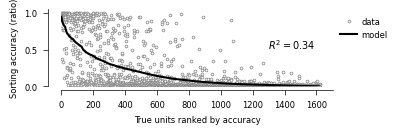

In [52]:
# parameters
MARKEREDGEWIDTH = 0.5
ALPHA = 1
LINEWIDTH = 1.5
MARKERSIZE = 2

# compute predictions
fullmodel = fullresults["metric_data"]["model"]
weights = fullmodel.params
prediction = fullmodel.model.predict(weights)

# add predictions to dataset
dataset2 = copy.copy(dataset)
dataset2 = dataset2.dropna()
dataset2["prediction"] = prediction

# sort dataset by prediction ascending order
df_sorted = dataset2.sort_values(by="prediction", ascending=False)

# plot
fig, ax = plt.subplots(1, figsize=(3.5, 1))

# data
ax.plot(
    df_sorted["sorting_accuracy"].values,
    "o",
    color="w",
    markeredgecolor=(0.5, 0.5, 0.5),
    markeredgewidth=MARKEREDGEWIDTH,
    markersize=MARKERSIZE,
    label="data",
    alpha=ALPHA,
)

# predictions
ax.plot(
    df_sorted["prediction"].values,
    "-",
    color=(0, 0, 0),
    linewidth=LINEWIDTH,
    label="model",
)

# annotate cross-validated r-square
r2 = np.round(flc_results["metric_stats"]["r2_median"], 2)
ax.annotate(
    text=f"$R^2=${r2}",
    xy=(0.8 * dataset2.shape[0], 0.5),
    color="k",
    fontsize=7,
)

# aesthetics
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("True units ranked by accuracy")
ax.set_ylabel("Sorting accuracy (ratio)")
ax.legend(**legend_cfg, bbox_to_anchor=(1, 1), loc="upper left")

# disconnect axes (R style)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)

# save figure
utils.savefig("figures/2_causes/assets/fig6E_prediction_E_ks4.svg")

### Weights

In [13]:
def interpret_features_weights(model_results):

    # build table of features contributions  ---------------
    weights = model_results.params

    # add feature weights
    weights_for_df = weights.drop(index="Intercept")
    weights_df = weights_for_df.to_frame()
    weights_df.columns = ["weights"]

    # add p-values (fit to entire dataset)
    pvalues_df = model_results.pvalues.drop(index="Intercept")
    pvalues_df = pvalues_df.to_frame()
    pvalues_df.columns = ["p-value"]
    data_df = pd.merge(
        weights_df,
        pvalues_df,
        left_index=True,
        right_index=True,
    )

    # interpret interceptsl
    print("Intercept:")
    print("- logodds of detected HQ units:", weights["Intercept"])
    odds = np.exp(weights["Intercept"])
    print(
        "- P(Identified HQ units when all features are null):",
        odds / (1 + odds),
    )

    # interpret all features
    odds = np.exp(weights["Intercept"] + data_df["weights"])
    data_df[r"\Delta accuracy"] = np.sign(data_df["weights"]) * odds / (1 + odds)

    # display
    data_df = data_df.sort_values(by=["weights"], ascending=False)
    return data_df

Intercept:
- logodds of detected HQ units: -2.5458857229428182
- P(Identified HQ units when all features are null): 0.07270337285188012


,weights,p-value,\Delta accuracy
firing_rate,0.654834,2.372056e-15,0.131125
spatial_extent,0.297282,2.367571e-04,0.095470
layer_5,0.293804,4.804495e-05,0.095170
synapse_class,0.190271,2.218322e-05,0.086621
cADpyr,0.190271,2.218322e-05,0.086621
layer_4,-0.011801,8.796939e-01,-0.071912
cACint,0.090125,2.141600e-01,0.079018
dynamics_holding_current,-0.104107,3.229816e-01,-0.065989
dSTUT,-0.060664,7.175499e-01,-0.068718
layer_1,-0.027594,6.996207e-01,-0.070865


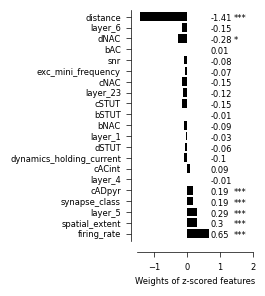

In [50]:
# calculate weight table
table_data = interpret_features_weights(fullresults["metric_data"]["model"])

# set feature order same as NS dataset
feature_order = [
    "firing_rate",
    "spatial_extent",
    "layer_5",
    "synapse_class",
    "cADpyr",
    "layer_4",
    "cACint",
    "dynamics_holding_current",
    "dSTUT",
    "layer_1",
    "bNAC",
    "bSTUT",
    "cSTUT",
    "layer_23",
    "cNAC",
    "exc_mini_frequency",
    "snr",
    "bAC",
    "dNAC",
    "layer_6",
    "distance",
]

# display table
table_data = table_data.reindex(feature_order)
display(table_data)

# plot
fig, ax = plt.subplots(1, 1, figsize=(1.5, 3))
ax = table_data.plot.barh(ax=ax, y="weights", color="k", width=0.8)

# annotate with p-value symbols
for ix in range(len(table_data["weights"])):
    text = ""
    if (table_data["p-value"].iloc[ix] < 0.05) and (
        table_data["p-value"].iloc[ix] >= 0.01
    ):
        text = "*"
    elif (table_data["p-value"].iloc[ix] < 0.01) and (
        table_data["p-value"].iloc[ix] >= 0.001
    ):
        text = "**"
    elif table_data["p-value"].iloc[ix] < 0.001:
        text = "***"
    ax.annotate(
        text=text,
        xy=(
            1.4,
            ix - 0.4,
        ),
    )
    ax.annotate(
        text=np.round(table_data["weights"].iloc[ix], 2),
        xy=(
            0.7,
            ix - 0.4,
        ),
    )

# aesthetics
ax.set_xlim([ax.get_xlim()[0], 2])
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)

# no legend
ax.legend().set_visible(False)
ax.set_xlabel("Weights of z-scored features")

# save figure
utils.savefig("figures/2_causes/assets/fig6F_weights_frmodel_E_ks4.svg")

### References

https://github.com/statsmodels/statsmodels/issues/9048
https://www.statsmodels.org/dev/examples/notebooks/generated/quasibinomial.html

https://www3.nd.edu/~rwilliam/stats3/L05.pdf

Mcfadden pseudo R2 equation:  
https://timeseriesreasoning.com/contents/r-squared-adjusted-r-squared-pseudo-r-squared/#:~:text=McFadden%27s%20Pseudo%2DR²%20is%20implemented,your%20fitted%20nonlinear%20regression%20model.

Mcfadden pseudo R2 interpretation (between 0.2 and 0.4 indicates excellent fit)  
https://stats.stackexchange.com/questions/82105/mcfaddens-pseudo-r2-interpretation

https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html

https://stats.stackexchange.com/questions/386675/what-are-weights-in-a-binary-glm-and-how-to-calculate-them

https://stackoverflow.com/questions/72329673/binomial-glm-in-r-what-do-the-coefficients-talk-about
* **interpret weights**